In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from itertools import izip

In [2]:
import tensorflow as tf
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import models
from tensorflow.python.keras import losses

//anaconda/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
//anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


# Read 256x256 images in directory

In [3]:
# we create two instances with the same arguments
train_data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rotation_range=3.,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2)
train_image_datagen = ImageDataGenerator(**train_data_gen_args)
train_mask_datagen = ImageDataGenerator(**train_data_gen_args)

val_data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rotation_range=0,
                     width_shift_range=0,
                     height_shift_range=0,
                     zoom_range=0)
val_image_datagen = ImageDataGenerator(**val_data_gen_args)
val_mask_datagen = ImageDataGenerator(**val_data_gen_args)

In [4]:
# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
batch_size = 10
train_image_generator = train_image_datagen.flow_from_directory(
    'shift35_imgs/train/images',
    color_mode="grayscale",
    class_mode=None,
    seed=seed,
    batch_size=batch_size)

train_mask_generator = train_mask_datagen.flow_from_directory(
    'shift35_imgs/train/masks',
    color_mode="grayscale",
    class_mode=None,
    seed=seed,
    batch_size=batch_size)

# combine generators into one which yields image and masks at desired batch_size
# must use izip
train_generator = izip(train_image_generator, train_mask_generator)

val_image_generator = val_image_datagen.flow_from_directory(
    'shift35_imgs/val/images',
    color_mode="grayscale",
    class_mode=None,
    seed=seed,
    batch_size=batch_size)

val_mask_generator = val_mask_datagen.flow_from_directory(
    'shift35_imgs/val/masks',
    color_mode="grayscale",
    class_mode=None,
    seed=seed,
    batch_size=batch_size)

val_generator = izip(val_image_generator, val_mask_generator)
# image_datagen.fit(images, augment=True, seed=seed)
# mask_datagen.fit(masks, augment=True, seed=seed)

Found 80 images belonging to 1 classes.
Found 80 images belonging to 1 classes.
Found 20 images belonging to 1 classes.
Found 20 images belonging to 1 classes.


In [6]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [7]:
try: 
    model
except:
    model = models.load_model('weights_20181009_e20.hdf5', custom_objects={'bce_dice_loss': bce_dice_loss,
                                                           'dice_loss': dice_loss})

In [8]:
test_imgs = val_image_generator.next()
test_masks = val_mask_generator.next()
# Let's visualize some of the outputs 
predictions = model.predict_on_batch(test_imgs)

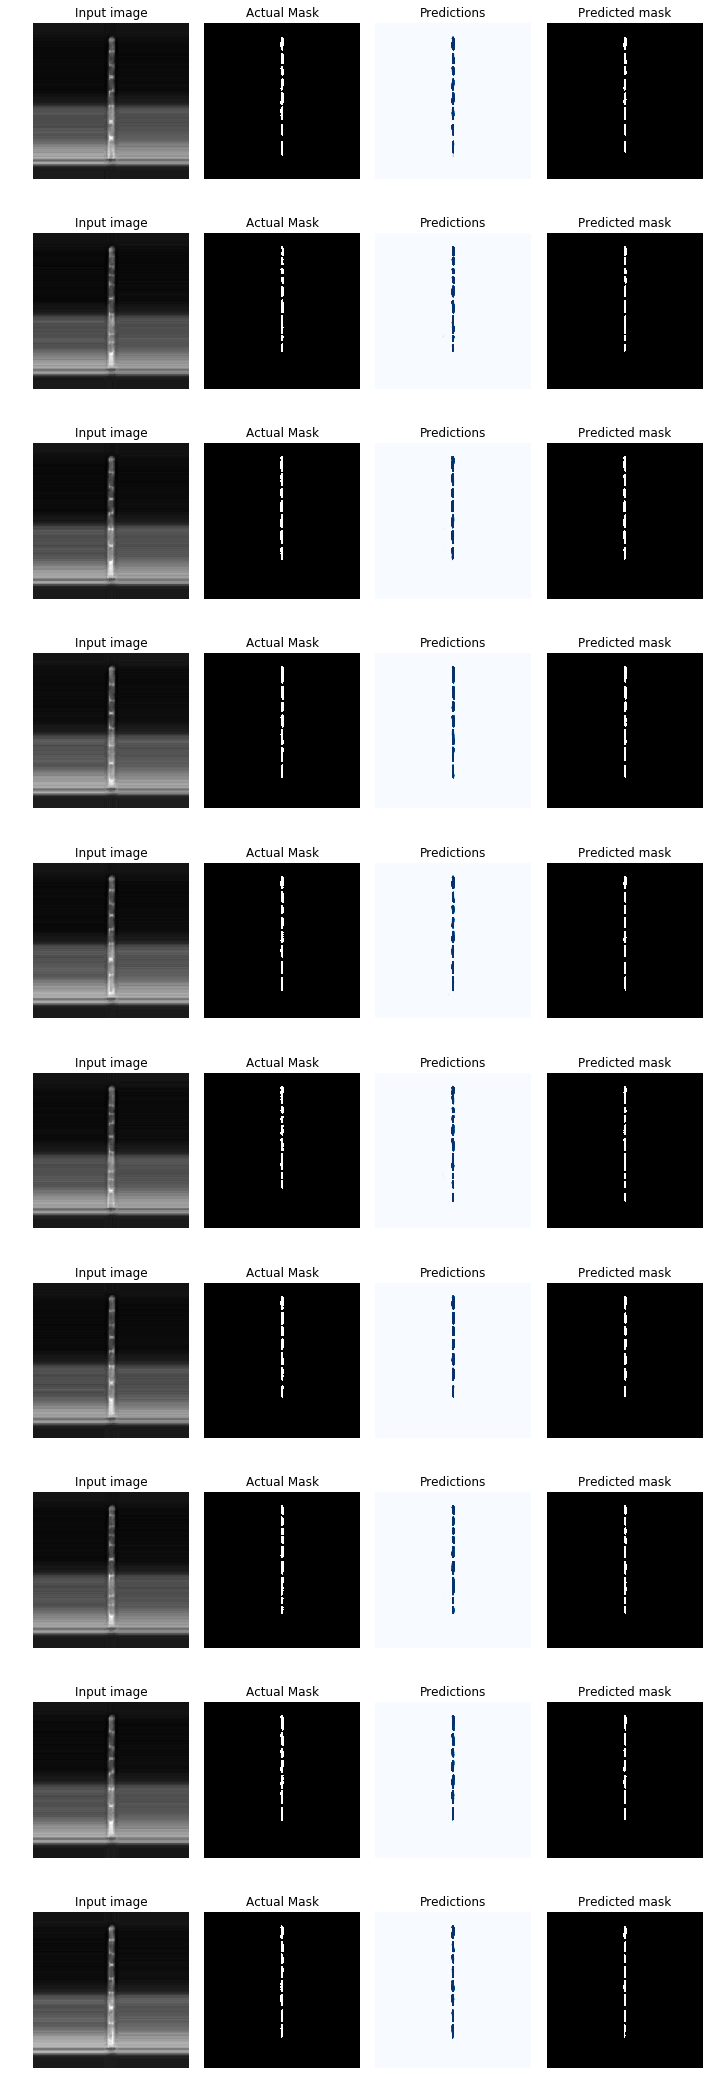

In [9]:
plt.rc('figure', titlesize=2)

# Running next element in our graph will produce a batch of images
fig = plt.figure(figsize=(10, 30))
n_imgs = 10
for i in range(10):
    img = test_imgs[i,:,:,0]
    label = test_masks[i,:,:,0]
    predicted_label = predictions[i,:,:,0]

    plt.subplot(10, 4, 4 * i + 1)
    plt.imshow(img, cmap=plt.cm.gray)
    plt.title("Input image")
    plt.axis('off')

    plt.subplot(10, 4, 4 * i + 2)
    plt.imshow(label, cmap=plt.cm.gray)
    plt.title("Actual Mask")
    plt.axis('off')
    
    plt.subplot(10, 4, 4 * i + 3)
    plt.imshow(predicted_label, cmap=plt.cm.Blues)
    plt.title("Predictions")
    plt.axis('off')
    
    plt.subplot(10, 4, 4 * i + 4)
    plt.imshow(predicted_label>0.99, cmap=plt.cm.gray)
    plt.title("Predicted mask")
    plt.axis('off')
    

plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=-0.1)
plt.show()

fig.savefig('./predictions_20181009.pdf', dpi=200)

In [13]:
sum(predicted_label>0.99)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0, 15, 29, 31, 31, 31, 30, 28, 13,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  5, 16,
       21, 23, 23, 23, 22, 19,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  7, 19, 49,
       55, 61, 62, 61, 53, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0